# Corpus Building Notebook

In [1]:
#Install libraries

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm
from collections import Counter

In [2]:
#Installing client - run below command in terminal

#pip install pyalex #pyalex client: https://github.com/J535D165/pyalex

## Seed Sources

### Create and Obtain List of Seed Sources

In [3]:
#TODO: Fill in the rest of our seed sources in DOI_list below
DOI_list = ['https://doi.org/10.1098/rsta.2017.0357',
           'https://doi.org/10.1098/rsta.2017.0359',
           'https://doi.org/10.1146/annurev-lawsocsci-041221-023808',
           '10.1080/14719037.2022.2048685',
           'https://doi.org/10.1145/3476089',
           'https://doi.org/10.1162/DAED_a_01922',
           'https://doi.org/10.1098/rsta.2017.0364']

### Grab Information for Each Seed Source

In [4]:
#Initializing pyalex client
from pyalex import Works, Authors, Venues, Institutions, Concepts
import pyalex #The polite pool has much faster and more consistent response times.
pyalex.config.email = "zmintz@utexas.edu" #To get into the polite pool, you set your email

In [5]:
#Pull list of seed DOIs in OpenAlex API
# pipe_separated_DOI_list = "|".join(DOI_list)
# r = requests.get(f"https://api.openalex.org/works?filter=doi:{pipe_separated_DOI_list}&per-page=50&mailto=support@openalex.org")
# works = r.json()["results"]

In [6]:
#Pull list of seed DOIs in OpenAlex API
pipe_separated_DOI_list = "|".join(DOI_list)

#Grab citations and references from each seed source
grabbed_seed_sources_dicts = Works().filter(doi=pipe_separated_DOI_list, is_oa=True).get()

#Check how many we grabbed
print("Grabbed %d out of %d articles" % (len(grabbed_seed_sources_dicts), len(DOI_list)))

#If we need to investigate which dois didn't get grabbed
#grabbed_DOI_list = [dict["doi"] for dict in grabbed_seed_sources_dicts]
#grabbed_DOI_list

Grabbed 7 out of 7 articles


### Snapshot of One Work in Seed Source Dictionary 
JSON viewer: http://jsonviewer.stack.hu/ --> view json in tree here
JSON editor: https://jsoneditoronline.org/#left=local.zacayi --> reformat output here

Pertinent attributes in dictionary include
* id : "https://openalex.org/W3186947646"
* doi : "https://doi.org/10.1146/annurev-lawsocsci-041221-023808"
* title : "Algorithms and Decision-Making in the Public Sector"
* display_name : "Algorithms and Decision-Making in the Public Sector"
* publication_year : 2021
* publication_date : "2021-10-13"
* ids
* primary_location
* host_venue
* type : "journal-article"
* open_access
* authorships
* cited_by_count : 15
* biblio
* is_retracted : false
* is_paratext : false
* concepts
* mesh
* locations
* best_oa_location
* alternate_host_venues
* referenced_works
* related_works
* ngrams_url : "https://api.openalex.org/works/W3186947646/ngrams"
* abstract_inverted_index
* cited_by_api_url : "https://api.openalex.org/works?filter=cites:W3186947646"
* counts_by_year
* updated_date : "2023-02-23T16:34:40.366204"
* created_date : "2021-08-02"

## Obtain References and Related Works

### Get List of References and Related Works

In [7]:
#Get referenced works
ref_works_id_list = [dict["referenced_works"] for dict in grabbed_seed_sources_dicts]

#Get related works
related_works_id_list = [dict["related_works"] for dict in grabbed_seed_sources_dicts]

#Flatten list of lists and dedupe ids
ref_ids = [] #initialize
related_ids = []

non_deduped_ref = [item for sublist in ref_works_id_list for item in sublist]
non_deduped_rel = [item for sublist in related_works_id_list for item in sublist]
[ref_ids.append(item) for sublist in ref_works_id_list for item in sublist if item not in ref_ids]
[related_ids.append(item) for sublist in related_works_id_list for item in sublist if item not in related_ids]

print("Related Works: %d total, %d deduped" % (len(non_deduped_rel), len(related_ids)))
print("Referenced Works: %d total, %d deduped" % (len(non_deduped_ref), len(ref_ids)))

Related Works: 70 total, 61 deduped
Referenced Works: 361 total, 352 deduped


In [8]:
#Combine and dedupe the related works and referenced works
combined_rel_ref_ids = set(ref_ids + related_ids)
print("Total number of Deduped Referenced and Related Works:", len(combined_rel_ref_ids))

Total number of Deduped Referenced and Related Works: 413


### Grab Information for Each Reference

In [9]:
#Pull list of seed DOIs in OpenAlex API
# pipe_separated_ref_list = "|".join(ref_ids)

#OpenAlex API can only handle calls for 50 articles at once
pipe_separated_ref_list1 = "|".join(ref_ids[0:50])
pipe_separated_ref_list2 = "|".join(ref_ids[50:100])
pipe_separated_ref_list3 = "|".join(ref_ids[100:150])
pipe_separated_ref_list4 = "|".join(ref_ids[150:200])
pipe_separated_ref_list5 = "|".join(ref_ids[200:250])
pipe_separated_ref_list6 = "|".join(ref_ids[250:300])
pipe_separated_ref_list7 = "|".join(ref_ids[300::])

In [10]:
#OpenAlex is only grabbing ~half of the articles due to pagination 

#Not sure how to change this using the python wrapper
# grabbed_ref_works_dict1 = Works().filter(openalex=pipe_separated_ref_list1, is_oa=False, per_page=200).get()

r = requests.get(f"https://api.openalex.org/works?filter=openalex:{pipe_separated_ref_list1}&per-page=200&mailto=support@openalex.org")
works = r.json()["results"]
len(works)

50

# Functions for Corpus Building

In [11]:
import math

def openalex(article_list, id_type="doi"):
    article_batches = batch(article_list)
    results = []
    #iterate through batches of 50 articles 
    for i in article_batches:
        piped_article_batch='|'.join(i)
        url=f'https://api.openalex.org/works?filter={id_type}:{piped_article_batch}&per-page=50&cursor=*&mailto=support@openalex.org'
        req=requests.get(url).json()
        results += req['results']
    if len(results) == len(article_list):
        return results
    else:
        return results
        print("Number of articles in (%s) does not equal number returned (%s)" % (len(article_list), len(results)))
        #raise Exception("Number of articles in (%s) does not equal number returned (%s)" % (len(article_list), len(results))) # Make sure all results are returned; otherwise, raise errors.

    
def batch(articles):
    batched_articles = []
    for i in range(0, len(articles), 50):
        batched_articles += [articles[i:i + 50]]
    return batched_articles

In [12]:
def grab_references(openalex_list):
    #Get referenced works
    ref_works_id_list = [dict["referenced_works"] for dict in openalex_list]
    print("num of ref works %s" % (len(ref_works_id_list)))

    #Get related works
    related_works_id_list = [dict["related_works"] for dict in openalex_list]
    print("num of rel works %s" % (len(related_works_id_list)))

    #Flatten list of lists and dedupe ids
    ref_ids = [] #initialize
    related_ids = []

    non_deduped_ref = [item for sublist in ref_works_id_list for item in sublist]
    non_deduped_rel = [item for sublist in related_works_id_list for item in sublist]
    [ref_ids.append(item) for sublist in ref_works_id_list for item in sublist if item not in ref_ids]
    [related_ids.append(item) for sublist in related_works_id_list for item in sublist if item not in related_ids]

    print("Related Works: %d total, %d deduped" % (len(non_deduped_rel), len(related_ids)))
    print("Referenced Works: %d total, %d deduped" % (len(non_deduped_ref), len(ref_ids)))
    
    combined_rel_ref_ids = set(ref_ids + related_ids)
    print("Total number of Deduped Referenced and Related Works:", len(combined_rel_ref_ids))
    
    #dedupe the seed sources from references
    return openalex(list(combined_rel_ref_ids), id_type="openalex")

In [13]:
full_seed_src = ["10.1162/daed_a_01922",
                 "10.1098/rsta.2017.0364",
                 "10.1007/978-3-030-92644-1",
                 # "10.2307/48662048", 
                 "10.1111/puar.12979",
                 "10.3390/pr8111374",
                 "10.1002/poi3.165",
                 "10.1145/3476089",
                 "10.1080/14719037.2022.2048685",
                 "10.1146/annurev-lawsocsci-041221-023808",
                 # "10.2307/26601757",
                 # "10.2307/26601763",
                 "10.1177/08944393211034087",
                 "10.1145/3025453.3025579",
                 "10.1016/j.giq.2005.11.005",
                 "10.1016/j.techsoc.2016.07.001",
                 "10.3390/su11205791",
                 # "10.2307/27170531"
                ]

full_seed_openalex = openalex(full_seed_src)
#full_seed_openalex
full_ref_openalex = grab_references(full_seed_openalex)




num of ref works 14
num of rel works 14
Related Works: 140 total, 129 deduped
Referenced Works: 606 total, 587 deduped
Total number of Deduped Referenced and Related Works: 716


# Abstract Cleaning

In [14]:
#grab each article's abstract information. Check to see nulls.

abstract_inverted_index_list = [] # initialize
for i in full_ref_openalex:
    abstract_inverted_index_list.append(i["abstract_inverted_index"])
    
print("Number of works in list: %d" % (len(abstract_inverted_index_list)))
print("Number of null works in list: %d" % (abstract_inverted_index_list.count(None)))

Number of works in list: 709
Number of null works in list: 80


In [15]:
#Drop nulls and check total abstracts

abstract_inverted_index_list = [i for i in abstract_inverted_index_list if i is not None]
len(abstract_inverted_index_list)

629

In [16]:
#Clean abstract data to make it ready for modeling

abstract_list = abstract_inverted_index_list

import re
remove_all = re.compile(r'[^a-zA-Z\s\']')
abstract_list_ = [remove_all.sub('', str(i)) for i in abstract_list]

abstract_list_clean = []
for i in abstract_list_:
    abstract_list_clean.append(i)
    abstract_list_clean = [" ".join(i.split()) for i in abstract_list_clean]
    abstract_list_clean = [i.replace("'","") for i in abstract_list_clean]

print("Number of abstracts cleaned: %d" % (len(abstract_list_clean)))
print("First 10 cleaned abstracts: \n %s" % (abstract_list_clean[0:10]))


Number of abstracts cleaned: 629
First 10 cleaned abstracts: 
 ['The resourcebased view can be positioned relative to at least three theoretical traditions SCPbased theories of industry determinants firm performance neoclassical microeconomics and evolutionary economics In the article only first these ways positioning resourcebased is explored This article briefly discusses some implications other two literatures it also empirical each different theories', 'We show that easily accessible digital records of behavior Facebook Likes can be used to automatically and accurately predict a range highly sensitive personal attributes including sexual orientation ethnicity religious political views personality traits intelligence happiness use addictive substances parental separation age gender The analysis presented is based on dataset over volunteers who provided their detailed demographic profiles the results several psychometric tests proposed model uses dimensionality reduction for preproce

# Topic Modeling with BERT

In [17]:
##Cleaning abstracts further using spacy to avoid stopwords ending up in topics when reassigning outliers
##A quick tutorial on spacy and other stop-word removal packages can be found: https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a

import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
#sw_spacy = en.Defaults.stop_words
#print(sw_spacy)  ##could be done here, but wanted to experiment with using lemmas to help with stopword removal

def lemmatize_pipe(doc):
    lemma_list = [str(tok.lemma_).lower() for tok in doc #for each word (tok) in each abstract, take undercased lemma
                  if tok.is_alpha and not tok.is_stop and len(tok)>1] #if token is not a number, not a stopword, and has more than 1 character
    return lemma_list #return all non-numerical, non-stopword tokens, greater than one character as undercased lemma

def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in en.pipe(texts): #because spacy (tokenizing, assigning POS, etc.) needs a string and we have a list, we need to pipe each abstract into a function that creates a list of strings 
        preproc_pipe.append(lemmatize_pipe(doc)) #removing stopwords and resulting in a list of lemmatized words from each abstract without stopwords / numbers / characters < 1
    return preproc_pipe

new_abstracts = preprocess_pipe(abstract_list_clean) #stopword free abstracts

##Making sure we are removing all extraneous articles within the abstract list so our topic models will read abstracts correctly

new_abstracts_ = [remove_all.sub('', str(i)) for i in new_abstracts]

new_abstracts_final = []
for i in new_abstracts_:
    new_abstracts_final.append(i)
    new_abstracts_final = [" ".join(i.split()) for i in new_abstracts_final]
    new_abstracts_final = [i.replace("'","") for i in new_abstracts_final]
    
print("Number of abstracts cleaned: %d" % (len(new_abstracts_final)))
print("First 10 cleaned abstracts: \n %s" % (new_abstracts_final[0:10]))

/Users/zandermintz/Desktop/2022-2023 Academic/Computational Methods (Python)/Project Literature_Seed Articles/CSS_local/ai_in_publicsector/AI_Policy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of abstracts cleaned: 629
First 10 cleaned abstracts: 
 ['resourcebased view position relative theoretical tradition scpbase theory industry determinant firm performance neoclassical microeconomic evolutionary economic article way positioning resourcebase explore article briefly discuss implication literature empirical different theory', 'easily accessible digital record behavior facebook likes automatically accurately predict range highly sensitive personal attribute include sexual orientation ethnicity religious political view personality trait intelligence happiness use addictive substance parental separation age gender analysis present base dataset volunteer provide detailed demographic profile result psychometric test propose model use dimensionality reduction preprocesse likes datum enter logisticlinear regression individual psychodemographic profile likes correctly discriminate homosexual heterosexual man case african americans caucasian democrat republican case trait ope

In [18]:
##Creating a list of key words directly from our corpus to help guide our topic representation. To do this, we use
##KeyBERT which allows us to extract keywords in a similar fashion to BERTopic. Adds another supervised layer to the model.

from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

##creating loop of extracted keywords to ensure that we only include keywords that are important.

def keywords_tolist(keyword_list, min_count = 2):
    kw_strings = [[tuple[0] for tuple in list] for list in keyword_list]
    kw_flat = [item for sublist in kw_strings for item in sublist]
    kw_counts = pd.Series(kw_flat).value_counts()
    kw_top = kw_counts[kw_counts >= min_count].index.tolist()
    print('Total Unique Keywords:', len(kw_counts))
    print(kw_counts.head(50))
    return kw_top

##Running the KeyBERT model to produce keywords and then cleaning it up with the above loop to show only keywords that meet a certain similarity threshold.

##To diversify the results, we can use Maximal Margin Relevance (MMR) to create keywords / keyphrases which is based on cosine similarity.
##Levers to pull in this stage include min_freq and diversity parameters. Adjusting min_freq up decreases total number of unique keywords. 
##Adjusting diversity up increases the dissimilarity of keywords. 

min_freq = round(len(new_abstracts_final)*0.025) #word needs to be in at least 25% of documents for it to be a keyword
min_freq
vectorizer = KeyphraseCountVectorizer(min_df=min_freq)
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(new_abstracts_final, vectorizer = vectorizer, use_mmr = True, diversity = 0.5)
keywords_list = keywords_tolist(keywords, min_count = 2)

Total Unique Keywords: 272
datum                      75
artificial intelligence    64
development                58
application                54
algorithm                  51
framework                  47
technology                 44
sector                     43
management                 41
research                   40
public sector              39
propose                    38
innovation                 38
risk                       37
organization               35
impact                     34
assessment                 34
design                     33
process                    31
transparency               31
practice                   29
vehicle                    28
behavior                   28
system                     27
analyze                    26
policy                     26
service                    25
information                25
concept                    25
accountability             25
governance                 25
environment                24
stakeholder  

In [36]:
##Using BERTopic for Topic Modeling
#check supporting documentation: https://maartengr.github.io/BERTopic/index.html

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer


# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=50, n_components=10, min_dist=0.0, metric='cosine', low_memory=False)

# Step 3 - Cluster reduced embeddings. lever to adjust number of clusters / topics
hdbscan_model = HDBSCAN(min_cluster_size=7, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(vocabulary=keywords_list, stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with MMR. Decreases redundancy and improves diversity of keywords.
representation_model = MaximalMarginalRelevance(diversity=0.3)

# All steps together
topic_model = BERTopic(
  #min_topic_size = 10,
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Create topic representation
  #seed_topic_list = keywords_list,          # Step 5a - Add keyword list based on KeyBERT output & finetuning
  representation_model=representation_model,# Step 6 - (Optional) Fine-tune topic represenation 
  calculate_probabilities=True,        
  verbose=True
)


In [37]:
#fitting the model to our abstracts
topics, probs = topic_model.fit_transform(new_abstracts_final)

##Saving the model

#topic_model.save("my_model")


Batches: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
2023-05-10 11:29:21,927 - BERTopic - Transformed documents to Embeddings
2023-05-10 11:29:23,225 - BERTopic - Reduced dimensionality
2023-05-10 11:29:23,248 - BERTopic - Clustered reduced embeddings
/Users/zandermintz/Desktop/2022-2023 Academic/Computational Methods (Python)/Project Literature_Seed Articles/CSS_local/ai_in_publicsector/AI_Policy/lib/python3.11/site-packages/bertopic/vectorizers/_ctfidf.py:69: RuntimeWarning:

divide by zero encountered in divide



### Load Saved Model From Github

In [38]:
# Seeing the topics and topic labels.

#First, loading saved model
#topic_model = BERTopic.load("my_model")

print(topic_model.get_topic_info())
topic_model.generate_topic_labels()

    Topic  Count                                               Name
0      -1    206  -1_egovernment_government_organization_bureauc...
1       0    120            0_fairness_bias_assessment_transparency
2       1     54             1_production_region_methodology_expert
3       2     41         2_governance_sector_government_development
4       3     36               3_vehicle_safety_environment_advance
5       4     32              4_city_sustainability_hci_interaction
6       5     28   5_transparency_accountability_institution_sector
7       6     26      6_acceptance_influence_measurement_innovation
8       7     22                         7_child_foster_risk_factor
9       8     14                       8_step_drive_risk_acceptance
10      9     13              9_platform_online_article_information
11     10     11                    10_hci_interaction_form_privacy
12     11     10       11_worker_organization_sector_administration
13     12      8              12_agent_law_behav

['-1_egovernment_government_organization',
 '0_fairness_bias_assessment',
 '1_production_region_methodology',
 '2_governance_sector_government',
 '3_vehicle_safety_environment',
 '4_city_sustainability_hci',
 '5_transparency_accountability_institution',
 '6_acceptance_influence_measurement',
 '7_child_foster_risk',
 '8_step_drive_risk',
 '9_platform_online_article',
 '10_hci_interaction_form',
 '11_worker_organization_sector',
 '12_agent_law_behaviour',
 '13_innovation_knowledge_integration']

In [39]:
##Reduce outlier attempts
##helpful documentation for choosing the most appropriate method: https://maartengr.github.io/BERTopic/getting_started/outlier_reduction/outlier_reduction.html

#new_topics = topic_model.reduce_outliers(new_abstracts_final, topics, strategy="c-tf-idf", threshold=0.1)
new_topics = topic_model.reduce_outliers(new_abstracts_final, topics, strategy="distributions")
#new_topics = topic_model.reduce_outliers(new_abstracts_final, topics, probabilities=probs, strategy="probabilities")
#new_topics = topic_model.reduce_outliers(new_abstracts_final, topics, strategy="embeddings")

topic_model.update_topics(new_abstracts_final, topics=new_topics) 
# Seeing the topics and topic labels
print(topic_model.get_topic_info())
topic_model.generate_topic_labels()

100%|██████████| 1/1 [00:00<00:00, 20.75it/s]


    Topic  Count                                         Name
0      -1      2                         -1_aa_aaaa_aaa_aaaaa
1       0    141            0_algorithm_system_decision_datum
2       1     76           1_model_policy_result_agricultural
3       2     90          2_ai_government_sector_intelligence
4       3     50            3_vehicle_autonomous_system_drive
5       4     43         4_city_smart_sustainability_research
6       5     39  5_transparency_accountability_public_sector
7       6     40           6_theory_model_adoption_technology
8       7     24                7_child_placement_risk_parent
9       8     26          8_mobility_transport_vehicle_method
10      9     22               9_platform_user_online_content
11     10     25             10_policy_hci_government_privacy
12     11     25        11_sector_public_organization_private
13     12     10               12_robot_ethic_agent_roboethic
14     13     16   13_enterprise_innovation_process_knowledge


['-1_aa_aaaa_aaa',
 '0_algorithm_system_decision',
 '1_model_policy_result',
 '2_ai_government_sector',
 '3_vehicle_autonomous_system',
 '4_city_smart_sustainability',
 '5_transparency_accountability_public',
 '6_theory_model_adoption',
 '7_child_placement_risk',
 '8_mobility_transport_vehicle',
 '9_platform_user_online',
 '10_policy_hci_government',
 '11_sector_public_organization',
 '12_robot_ethic_agent',
 '13_enterprise_innovation_process']

In [23]:
#Seeing document information to understand each topic, topic name, top words, probability and if 
#that document was representative of the topic

topic_model.get_document_info(new_abstracts_final)

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,resourcebased view position relative theoretic...,6,6_theory_model_technology_acceptance,theory - model - technology - acceptance - ado...,0.132438,False
1,easily accessible digital record behavior face...,11,11_platform_user_medium_online,platform - user - medium - online - article - ...,1.000000,False
2,short deliberately provocative paper reflect y...,9,9_transport_mobility_smart_vehicle,transport - mobility - smart - vehicle - chang...,0.066147,False
3,artificial intelligence machine learning perio...,0,0_algorithm_system_decision_work,algorithm - system - decision - work - algorit...,0.305728,False
4,intelligent vehicle increase capability highly...,4,4_vehicle_autonomous_drive_system,vehicle - autonomous - drive - system - perfor...,0.609100,False
...,...,...,...,...,...,...
624,autonomous adaptative cyberphysical systems ac...,9,9_transport_mobility_smart_vehicle,transport - mobility - smart - vehicle - chang...,0.070122,False
625,evident service play critical role hospitality...,13,13_sme_enterprise_innovation_process,sme - enterprise - innovation - process - rela...,0.245664,False
626,hnc question answer systemhncqais brandnew que...,5,5_method_algorithm_network_learn,method - algorithm - network - learn - model -...,0.048375,False
627,development technique parallel computing debug...,5,5_method_algorithm_network_learn,method - algorithm - network - learn - model -...,0.145651,False


In [24]:
##Searching the top 5 topics using keywords: https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic.approximate_distribution

##Finds topics most similar to a search_term
##Creates an embedding for search_term and compares that with the topic embeddings. 
##The most similar topics are returned along with their similarity values (in terms of probability).
##The search_term can be of any size but since it compares with the topic representation it is advised to keep it below 5 words.

print(topic_model.get_topic_info())
topic_model.find_topics("smart city", top_n=5)

    Topic  Count                                              Name
0      -1      3                              -1_aa_aaaa_aaa_aaaaa
1       0     98                  0_algorithm_system_decision_work
2       1     74                1_model_policy_result_agricultural
3       2     54                       2_city_paper_research_smart
4       3     90               3_ai_government_sector_intelligence
5       4     43                 4_vehicle_autonomous_drive_system
6       5     55                  5_method_algorithm_network_learn
7       6     40              6_theory_model_technology_acceptance
8       7     27                     7_child_risk_placement_parent
9       8     34  8_transparency_accountability_public_institution
10      9     26                9_transport_mobility_smart_vehicle
11     10     27                         10_policy_hci_work_public
12     11     19                    11_platform_user_medium_online
13     12     24             12_sector_organization_public_pri

([2, 9, 3, 10, 13],
 [0.5062918021427946,
  0.44532262276336215,
  0.42403247787041787,
  0.42024584193453574,
  0.37339633271537764])

In [25]:
topic_model.get_topic(12)

[('sector', 0.05386620457443861),
 ('organization', 0.04248276442800232),
 ('public', 0.03573811254979302),
 ('private', 0.03012617129891021),
 ('agency', 0.02733584556136572),
 ('difference', 0.026547400244676216),
 ('manager', 0.025269498333560354),
 ('work', 0.02512579034079416),
 ('employment', 0.02468795866728631),
 ('worker', 0.022717607860657206)]

In [40]:
#Visualizing the topics

#prepare embeddings
embeddings = embedding_model.encode(new_abstracts_final, show_progress_bar=False)

#Visualize the documents and topics on two dimensions
reduced_embeddings = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(new_abstracts_final, reduced_embeddings=reduced_embeddings)

In [41]:
##Creating a similarity matrix between topics by applying cosine similarities through those topic embeddings. 
##The result will be a matrix indicating how similar certain topics are to each other.

topic_model.visualize_heatmap(n_clusters = 5)

In [42]:
##Create Intertopic Distance Map to visualize the distance between topics.
topic_model.visualize_topics()


In [29]:
#Visualizing top 5 most frequently occuring words in each topic.

topic_model.visualize_barchart(top_n_topics = len(topics))

In [157]:
#create a shareable .ipynb file for others to view

file_output = 'corpus_building.ipynb'
!jupyter nbconvert --to html $file_output


[NbConvertApp] Converting notebook corpus_building.ipynb to html
[NbConvertApp] Writing 662329 bytes to corpus_building.html


### Top2Vec Modeling

In [30]:
from top2vec import Top2Vec
#check supporting documentation: https://pypi.org/project/top2vec/
#Below blurb is taken from: https://python-textbook.pythonhumanities.com/04_topic_modeling/04_03_04_top2vec.html

#Top2Vec will embed not only all the sentences, but all the words used in your corpus. 
#In addition to this, it will also embed the topics themselves. 
#This means that words, documents, and topics all occupy the same higher-dimensional space. 
#On the surface, this may not seem that important, 
#but it allows us to understand the relationship between three interconnected pieces of the process in topic modeling mathematically. 
#This means, for example, Top2Vec let’s us know the mathematical similarity between a given word and a document or a topic in general. 
#Understanding these relationships lets us understand broader patterns in our topics that may otherwise be missed.

#### Train Top2Vec model using parameters - taken from Ji Ma

def func_train_t2v(n_neighbors, min_dist, min_cluster_size, min_count, docs, embedding_model=None):

    umap_args = {
        "n_neighbors": n_neighbors,
        "n_components": 10, # Dimension of data vectors. Embedded document vector == 512, no reduction.
        "metric": "cosine",
        "min_dist":min_dist,
        "random_state":111, # Reproducible results. Verified. https://github.com/ddangelov/Top2Vec/issues/86#issuecomment-743328971
    }

    hdbscan_args = {
        'min_cluster_size': min_cluster_size,
        'metric': 'euclidean',
        'cluster_selection_method': 'leaf' # leaf: there will be a tendency to produce a more fine grained clustering than Excess of Mass (eom) can provide.
    }

    model = Top2Vec(docs, 
                    embedding_model=embedding_model, 
                    use_embedding_model_tokenizer=True,
                    min_count=min_count,
                    speed='deep-learn',   #speed: This parameter will determine how fast the model takes to train. The 'fast-learn' option is the fastest and will generate the lowest quality vectors. The 'learn' option will learn better quality vectors but take a longer time to train. The 'deep-learn' option will learn the best quality vectors but will take significant time to train.
                    workers=8,            #workers: The amount of worker threads to be used in training the model. Larger amount will lead to faster training.
                    umap_args=umap_args,
                    hdbscan_args=hdbscan_args,
                    use_corpus_file=True,
                   )
    return model

In [31]:
##Run documents through function
top2vec_model=func_train_t2v(n_neighbors=50, min_dist=0.0, min_cluster_size=7, min_count=5, docs=new_abstracts_final, embedding_model='doc2vec')

2023-05-10 11:26:42,053 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-05-10 11:26:42,118 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-05-10 11:26:50,466 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-05-10 11:26:51,837 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-05-10 11:26:51,848 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [32]:
##Understanding how many documents are in each topic

topic_sizes, topic_nums = top2vec_model.get_topic_sizes()

for topic_size, topic_num in zip(topic_sizes[:len(topic_sizes)], topic_nums[:len(topic_nums)]):
    print(f"Topic number {topic_num} has {topic_size} documents.") 

Topic number 0 has 65 documents.
Topic number 1 has 52 documents.
Topic number 2 has 38 documents.
Topic number 3 has 34 documents.
Topic number 4 has 34 documents.
Topic number 5 has 34 documents.
Topic number 6 has 34 documents.
Topic number 7 has 33 documents.
Topic number 8 has 32 documents.
Topic number 9 has 32 documents.
Topic number 10 has 31 documents.
Topic number 11 has 31 documents.
Topic number 12 has 30 documents.
Topic number 13 has 30 documents.
Topic number 14 has 26 documents.
Topic number 15 has 26 documents.
Topic number 16 has 26 documents.
Topic number 17 has 23 documents.
Topic number 18 has 18 documents.


In [33]:
##Looking at top five words per topic & their similiarity scores.

##In t2v, words, documents, and topics all occupy the same higher-dimensional space. 
##The higher the score, the closer a word is to a topic’s center and, therefore, 
##in theory more closely represents that cluster

topic_words, word_scores, ttopics = top2vec_model.get_topics()

for topic_word, word_score, ttopic in zip(topic_words[:len(topic_words)], word_scores[:len(word_scores)],ttopics[:len(ttopics)]):
    print(f"Topic {ttopic} \n {topic_word[:5]}, \n {word_score[:5]}")  

##Can see top 50 words and their scores for each topic using the below
print("" "\n \nTop 50 words their similarity scores for each topic.")
print(top2vec_model.get_topics(len(ttopics)))

Topic 0 
 ['vehicle' 'autonomous' 'selfdrive' 'transport' 'pedestrian'], 
 [0.7059824  0.65137553 0.5108032  0.505942   0.501563  ]
Topic 1 
 ['ethnographic' 'cscw' 'situate' 'month' 'audience'], 
 [0.6467289  0.54226756 0.38727558 0.38239434 0.37483492]
Topic 2 
 ['toe' 'readiness' 'determinant' 'pressure' 'adoption'], 
 [0.6169619  0.5542841  0.50556463 0.45628557 0.4445591 ]
Topic 3 
 ['payment' 'sme' 'ecommerce' 'trade' 'consultant'], 
 [0.6266353  0.49237543 0.45184073 0.4490598  0.4203575 ]
Topic 4 
 ['connection' 'policymake' 'sustainability' 'city' 'smart'], 
 [0.56776905 0.47210824 0.46552286 0.46516514 0.4394667 ]
Topic 5 
 ['farmer' 'farm' 'machinery' 'agricultural' 'agriculture'], 
 [0.5997081  0.57573813 0.57105505 0.5493147  0.53858715]
Topic 6 
 ['department' 'leader' 'carry' 'strengthen' 'administration'], 
 [0.66978407 0.65446347 0.40155357 0.39729372 0.3844199 ]
Topic 7 
 ['ubiquity' 'meeting' 'regulation' 'law' 'eu'], 
 [0.6328675  0.5690539  0.40521732 0.3641519  0.

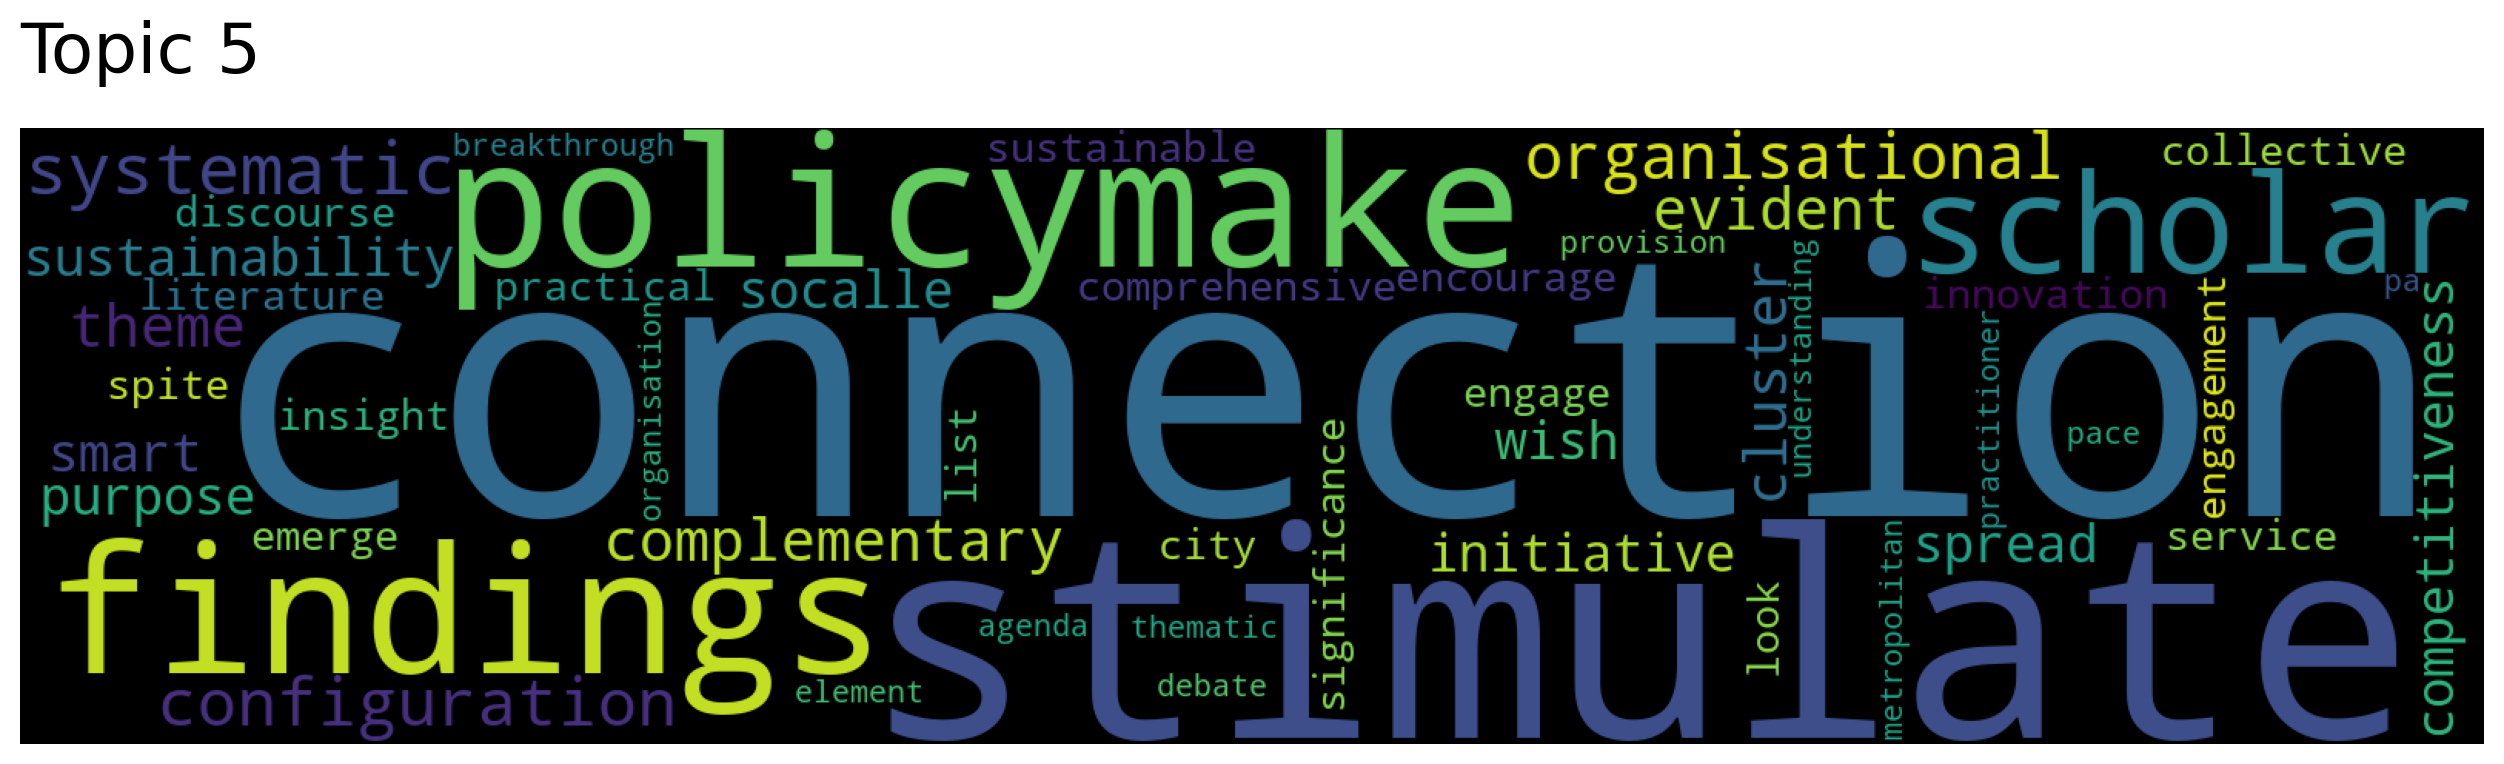

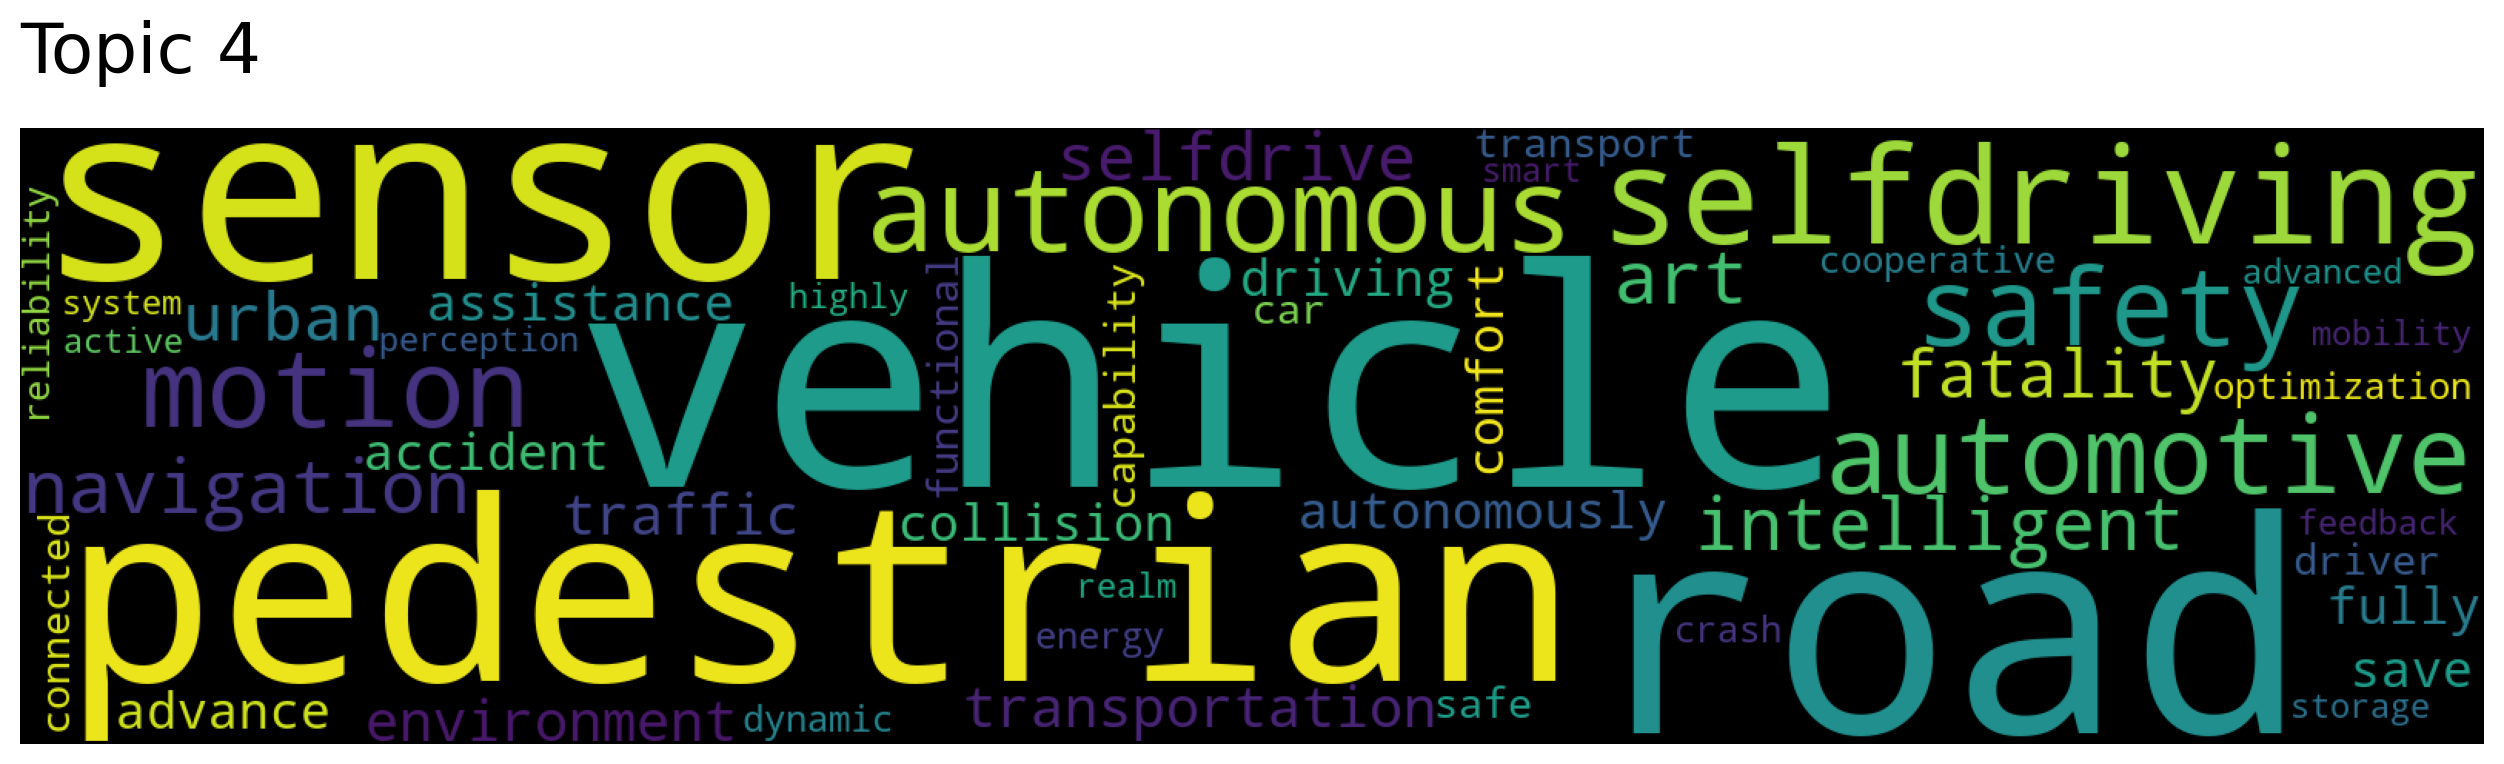

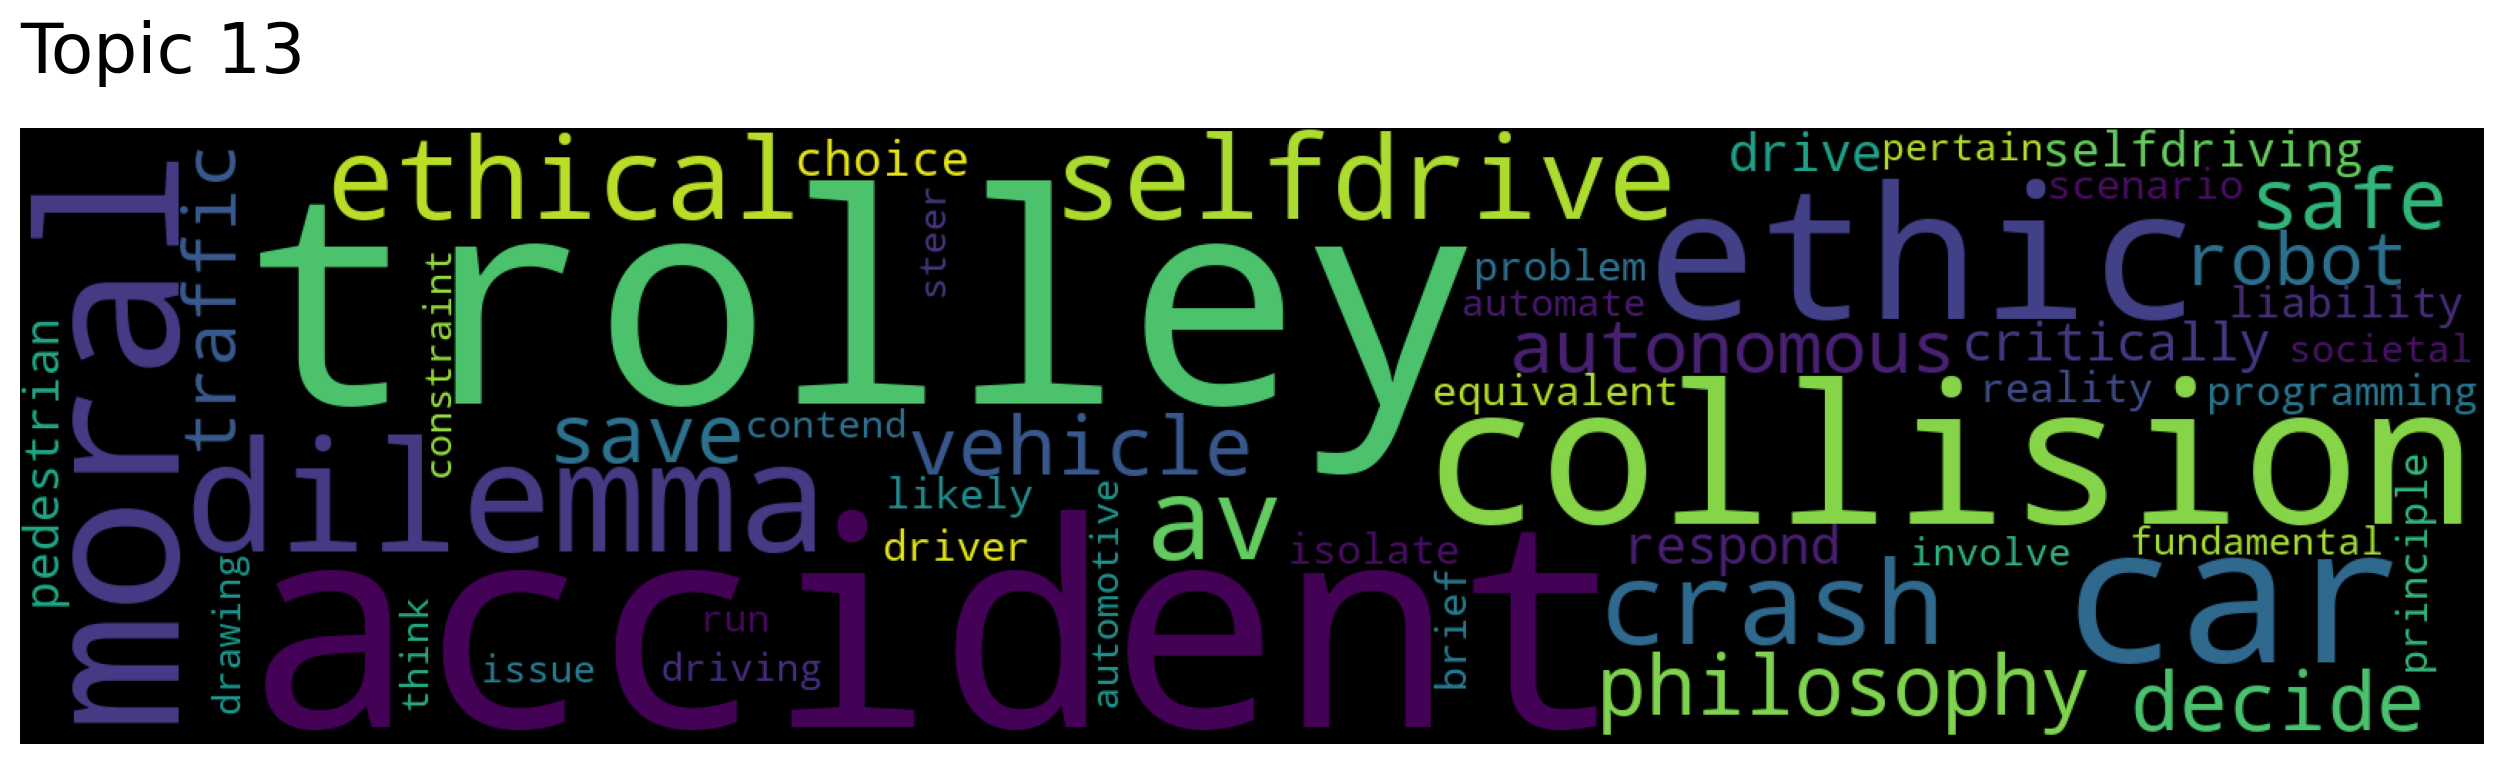

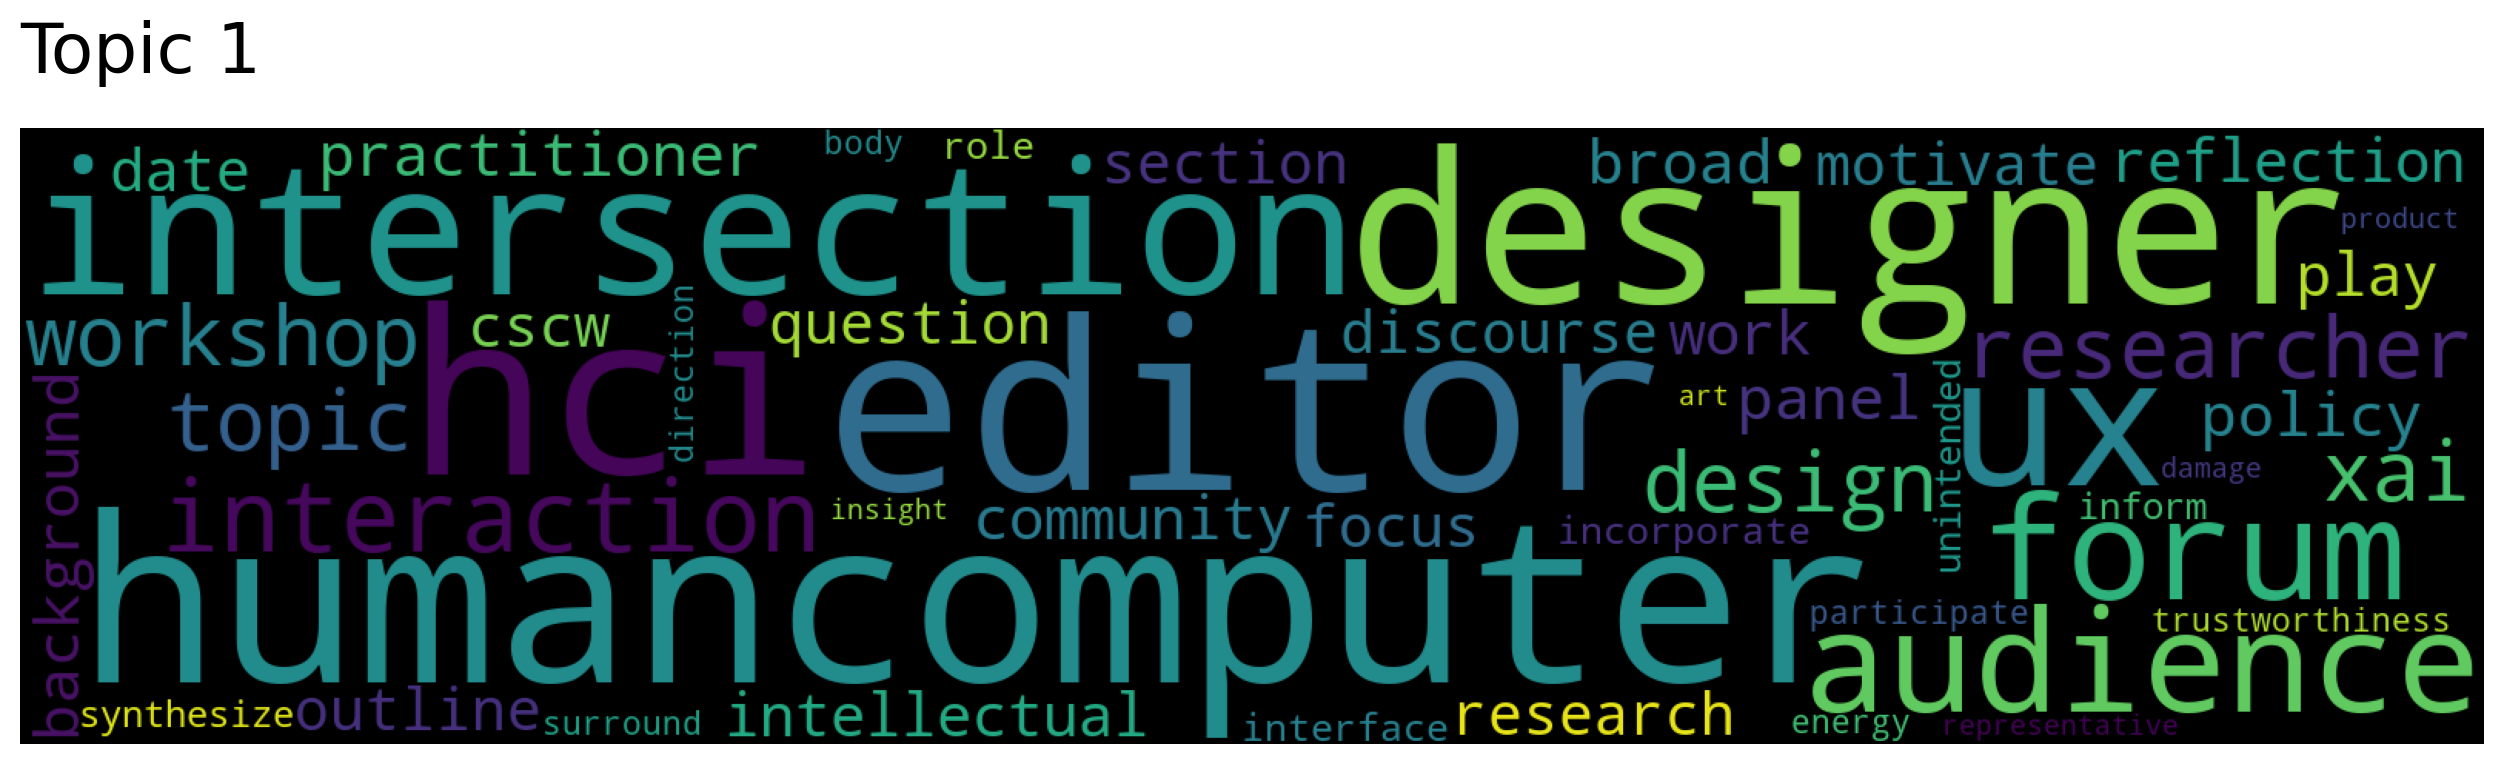

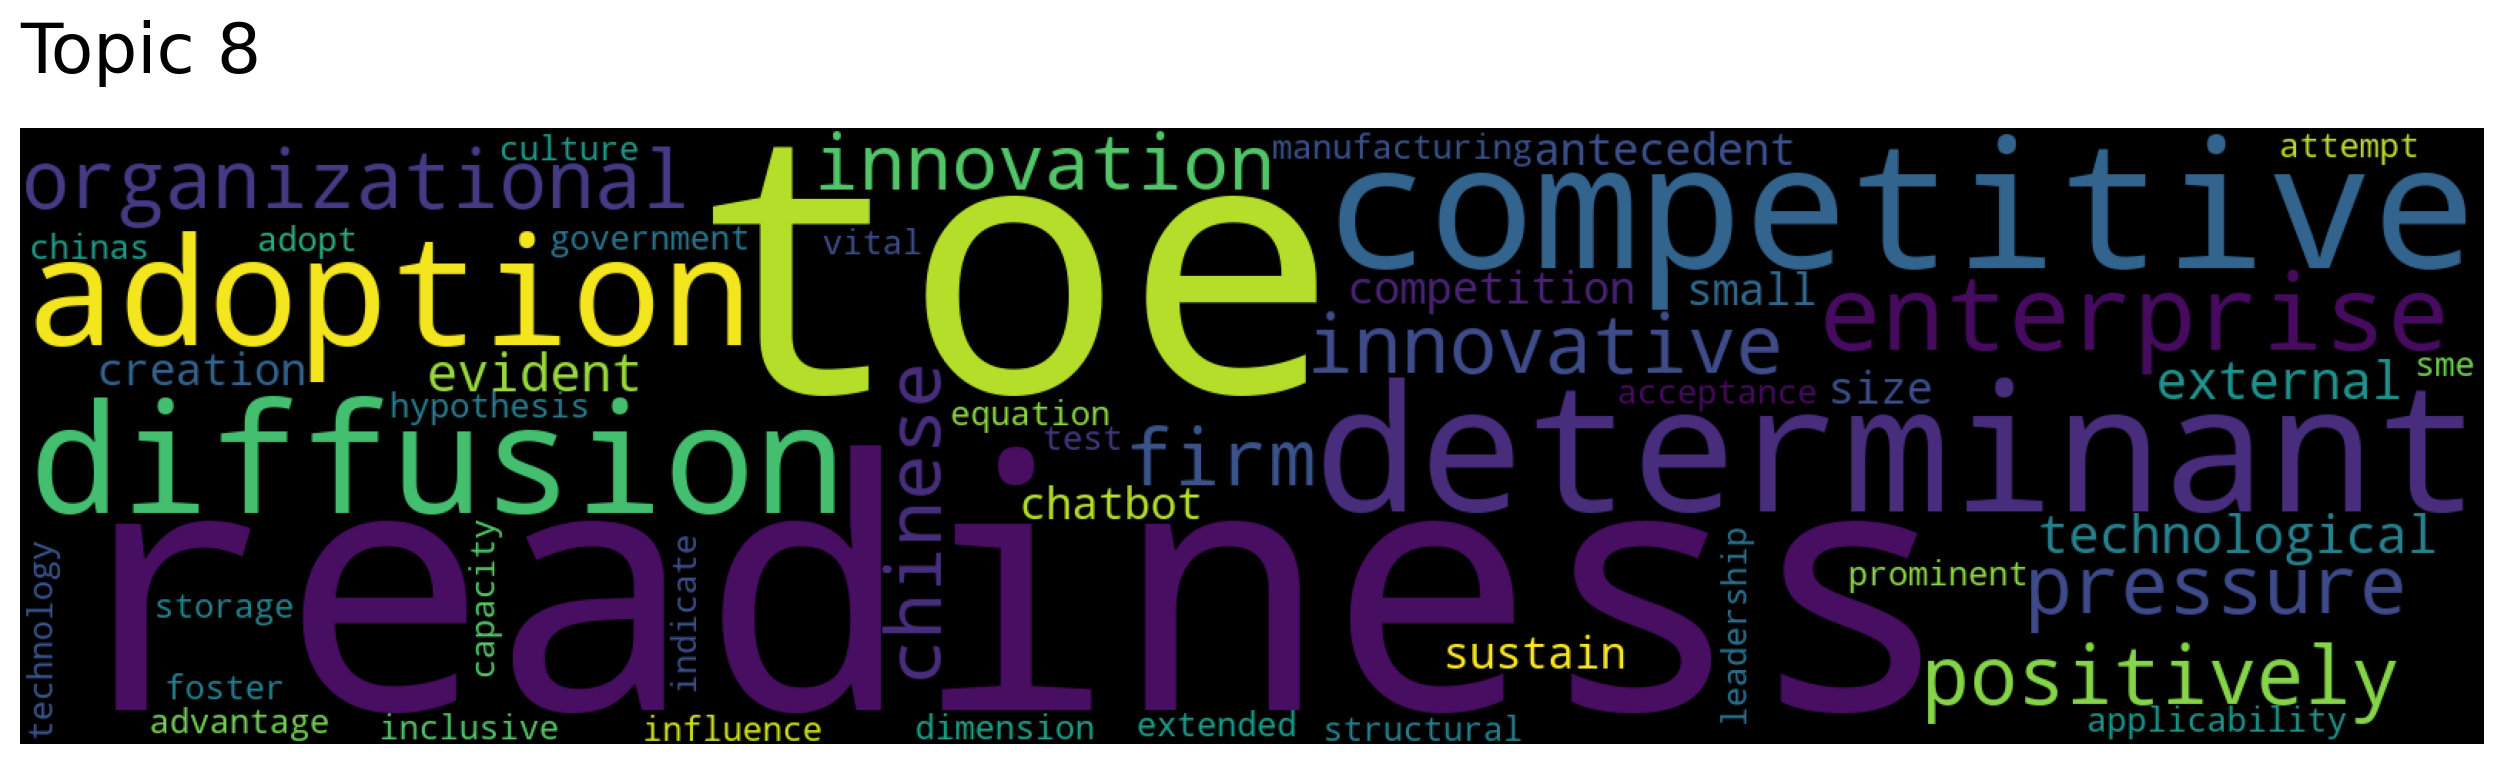

In [31]:
##Generating word clouds with top2vec for the top 5 most similar topics to search word(s)

topic_words, word_scores, topic_scores, topic_nums = top2vec_model.search_topics(keywords=["smart"], num_topics=5)
for topic in topic_nums:
    top2vec_model.generate_topic_wordcloud(topic)